# Spotify Song Daten auswerten mit RDDs in einem Spark Data Frame

**Kurzbeschreibung des kompletten Codes:**

**0.** Initialschritt (Dieser Schritt muss einmalig durchgeführt werden): Am Ende des Notebooks
       CSV File muss zunächst vorbearbeitet werden, dieser Schritt wird einmalig durchgeführt, dass CSV File wird dann auf dem Laptop gespeichert und das finale File kann in Schritt 1 eingebunden werden.

**1.** Der Code verarbeitet Pickle-Dateien parallel mit Spark, extrahiert relevante Daten, 
   filtert fehlerhafte Einträge und verbindet sie mit den CSV-Daten basierend auf einem gemeinsamen Schlüssel (track_uri).

**2.** Der Durchschnittsmodus über alle Songs, sowie pro Song wird berechnet

**3.** Die sections_pro_sekund und segments_pro_sekunde werden berechnet

**4.** Verschiedene Korrelationen werden berechnet: 
            - zwischen Energy und Loudness Max
            - zwischen Loudness Max und Danceability        
            - zwischen Energy und Danceability

**5.** Darstellung der Korrelationen in 3 Graphen. Da die Darstellung in pandas statt findet, funktioniert sie ab einer bestimmten Anzahl Dateien
   nicht mehr und ergibt einen Fehler. (bei 20.000 fehlerfrei, bei 50.000 fehler).


**Der komplette Code ist in einzelne Zellen unterteilt, jede der Zellen wird kurz beschrieben:**

**1)** Bibliotheken einbinden, Verzeichnisse definieren (Pickle Ordner und CSV Datei), Spark Session erstellen

In [2]:
import os
import time
import pickle
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, MapType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, size, when, round # für Schritt 5
from pyspark.sql.functions import regexp_extract # für Filtern der korrekten Track uri

# Spark-Session erstellen
spark = SparkSession.builder.appName("PickleToDataFramewithRDD").getOrCreate()

**2)** Die Verzeichnisse werden hier **einmalig definiert**, danach müssen diese nicht mehr im Code angepasst werden.

In [3]:
# Verzeichnis mit den Pickle-Dateien
pickle_dir = "C:/Users/katri/Documents/hka/adv_data_eng/data/100 Spotify Dataset/Cleaned Analyses"

# CSV-Datei in Spark laden
csv_path = "C:/Users/katri/Documents/hka/adv_data_eng/data/main_final_dataset.csv"

**3)** Schema für das Auslesen der Pickle Dateien definieren: Das ist das komplette Schema für den gesamten Inhalt einer
   Pickle Datei. Dadurch kann beliebig fest gelegt werden, auf welche Werte zugegriffen werden soll.

In [4]:
schema = StructType([
    StructField("meta", MapType(StringType(), StringType()), True),
    StructField("track", StructType([
        StructField("num_samples", IntegerType(), True),
        StructField("duration", FloatType(), True),
        StructField("loudness", FloatType(), True),
        StructField("tempo", FloatType(), True),
        StructField("tempo_confidence", FloatType(), True),
        StructField("key", IntegerType(), True),
        StructField("key_confidence", FloatType(), True),
        StructField("mode", IntegerType(), True),
        StructField("mode_confidence", FloatType(), True),
        StructField("time_signature", IntegerType(), True),
        StructField("time_signature_confidence", FloatType(), True),
    ]), True),
    StructField("bars", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("beats", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("sections", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
        StructField("tempo", FloatType(), True),
        StructField("tempo_confidence", FloatType(), True),
        StructField("key", IntegerType(), True),
        StructField("key_confidence", FloatType(), True),
        StructField("mode", IntegerType(), True),
        StructField("mode_confidence", FloatType(), True),
        StructField("time_signature", IntegerType(), True),
        StructField("time_signature_confidence", FloatType(), True),
    ])), True),
    StructField("segments", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
        StructField("loudness_start", FloatType(), True),
        StructField("loudness_max", FloatType(), True),
        StructField("loudness_max_time", FloatType(), True),
        StructField("pitches", ArrayType(FloatType()), True),
        StructField("timbre", ArrayType(FloatType()), True),
    ])), True),
    StructField("tatums", ArrayType(StructType([
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True),
        StructField("confidence", FloatType(), True),
    ])), True),
    StructField("track_uri", StringType(), True),
])


**4)** !! ACHTUNG !! Hier entsteht manchmal ein Fehler, wenn Kernel neugestartet wird geht es. 
Möglichkeit: Cache leeren?
Weitere Möglichkeiten suchen...
- **CSV wird folgendermaßen eingelesen:**
1) Nach jedem Komma folgt eine neue Spalte
2) Inhalte zwischen Anführungszeichen ("       ") sind eine einzige Spalte
- **Pickle-Daten einlesen**:  Pickle-Dateien werden aus einem Verzeichnis gesammelt und deren Daten werden in ein RDD umgewandelt.
- **Pickle-Daten verarbeiten**: Jede Pickle-Datei wird entpackt, relevante Felder extrahiert, und fehlerhafte Einträge werden gekennzeichnet.
- **Daten zusammenführen**: Das DataFrame der validen Pickle-Daten wird mit den CSV-Daten basierend auf der `track_uri` verbunden.
- **Statistik und Ergebnis**: Die Anzahl der verarbeiteten und fehlerhaften Dateien sowie die Zeilenanzahl vor und nach dem Join werden ausgegeben.


In [5]:
# Startzeit messen
start_time = time.time()

# CSV File einlesen: quote berücksichtigt das Inhalte zwischen " " als eine Spalte genommen werden
csv_df = spark.read.option("header", True).option("quote", '"').option("inferSchema", True).csv(csv_path)

# Alle Pickle-Dateien sammeln
pickle_files = [os.path.join(pickle_dir, f) for f in os.listdir(pickle_dir) if f.endswith(".pkl") or f.endswith(".pickle")]

# RDD erstellen basierend auf der Liste der Pickle-Dateien
pickle_rdd = spark.sparkContext.parallelize(pickle_files)

# Funktion zur Verarbeitung einer einzelnen Pickle-Datei
def process_pickle(filepath):
    try:
        with open(filepath, "rb") as file:
            pickle_data = pickle.load(file)
        
        # Extrahiere die benötigten Felder
        return {
            "track_uri": pickle_data.get("track_uri", "Unbekannt"),
            "bars": pickle_data.get("bars", []),
            "duration_ms": pickle_data.get("duration_ms", "Unbekannt"),
            "sections": pickle_data.get("sections", []),
            "segments": pickle_data.get("segments", []),
            "loudness_max": pickle_data.get("loudness_max", "Unbekannt"),
            "keys": pickle_data.get("keys", []),
            "track": pickle_data.get("track", [])
        }
    except Exception as e:
        return {"track_uri": None, "error": str(e)}

# Pickle-Dateien parallel verarbeiten
processed_rdd = pickle_rdd.map(process_pickle)

# RDD in Spark DataFrame umwandeln
pickle_df = spark.createDataFrame(processed_rdd, schema=schema)

# Fehlerhafte Einträge herausfiltern
valid_pickle_df = pickle_df.filter(pickle_df.track_uri.isNotNull())

# CSV-Daten mit Pickle-Daten verbinden
combined_df = valid_pickle_df.join(csv_df, valid_pickle_df["track_uri"] == csv_df["track_uri_csv"], how="inner")

# Join-Information fürs Debugging
print(f"JOIN Information:")
print(f"- Zeilen vor Join: {valid_pickle_df.count()}")
print(f"- Zeilen nach Join: {combined_df.count()}")
print("")

# Endzeit messen
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Codeausführung abgeschlossen. Dauer: {execution_time_minutes:.2f} Minuten")

JOIN Information:
- Zeilen vor Join: 100
- Zeilen nach Join: 100

Codeausführung abgeschlossen. Dauer: 0.66 Minuten


In [6]:
# Statistik anzeigen
total_files = len(pickle_files)
successful_files = valid_pickle_df.count()
failed_files = total_files - successful_files

print(f"Statistik:")
print(f"- Gesamtanzahl der Dateien: {total_files}")
print(f"- Erfolgreich verarbeitet: {successful_files}")
print(f"- Fehlerhaft: {failed_files}")

# Test, ob CSV und Pickle korrekt gejoint wurden: 
combined_df.select("track_uri", "track_uri_csv", "name", "duration_ms").show(n=100, truncate=False)

Statistik:
- Gesamtanzahl der Dateien: 100
- Erfolgreich verarbeitet: 100
- Fehlerhaft: 0
+------------------------------------+------------------------------------+----------------------------------------------------------------+-----------+
|track_uri                           |track_uri_csv                       |name                                                            |duration_ms|
+------------------------------------+------------------------------------+----------------------------------------------------------------+-----------+
|spotify:track:1cm9uduXJUwIUOqIESdlsL|spotify:track:1cm9uduXJUwIUOqIESdlsL|Scarlatti, D: Sinfonia No. 5 in A Minor: I. Allegrissimo        |39067.0    |
|spotify:track:5E8djSHnmvGSnupEF6t35w|spotify:track:5E8djSHnmvGSnupEF6t35w|Are You Sitting Comfortably?                                    |209693.0   |
|spotify:track:3k8fUMuDZrKt2rrq5qD8Hz|spotify:track:3k8fUMuDZrKt2rrq5qD8Hz|I Feel Like Going Home                                          |18973

**5)** Berechnung der Modes (Major = 1 und Minor = 0)

In [7]:
# Startzeit messen
start_time = time.time()

# 1. Berechnung des Durchschnittsmodus und Major-Prozentsatz für alle Songs
# Erstelle eine neue Spalte, die 1 ist, wenn der Modus 'Major' (1) ist, sonst 0
combined_df = combined_df.withColumn("is_major", F.when(combined_df["mode"] == 1, 1).otherwise(0))

# Gruppiere nach einer geeigneten Ebene (falls erforderlich, z.B. über alle Daten)
mode_stats = combined_df.agg(round(F.mean("is_major")*100,2).alias("major_percentage"))

# Ergebnisse anzeigen
mode_stats.show()

# Endzeit messen
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Codeausführung abgeschlossen. Dauer: {execution_time_minutes:.2f} Minuten")

+----------------+
|major_percentage|
+----------------+
|            65.0|
+----------------+

Codeausführung abgeschlossen. Dauer: 0.16 Minuten


In [ ]:
# Optional: Ausgabe für lesbaren Major-Prozentsatz
major_percentage = mode_stats.collect()[0]["major_percentage"] * 100
average_mode = mode_stats.collect()[0]["average_mode"]

print(f"Durchschnittsmodus: {average_mode}")
print(f"Major-Prozentsatz: {major_percentage:.2f}%")

# 2. Gruppierung nach Song und Berechnung der Werte (ganze Werte, da mode Werte aus Csv)
mode_stats_per_song = combined_df.groupBy("track_uri", "name").agg(F.mean("mode").alias("average_mode"), F.mean("is_major").alias("major_percentage"))

# Ergebnisse anzeigen
mode_stats_per_song.show(truncate=False)

#------------------------------------------------------------------------------------------------------------------------------------------

# 3. Gruppierung nach Song und Berechnung der Werte (Durchschnittswerte, da Mode aus Pickle Sections) 

# Explodiere die sections, sodass jede Section in einer eigenen Zeile steht
sections_exploded = combined_df.select("track_uri", "name", F.explode("sections").alias("section"))

# Extrahiere den Modus jeder Section
sections_with_mode = sections_exploded.select("track_uri", "name", sections_exploded.section["mode"].alias("mode"))

# Berechne den Durchschnittsmodus pro Song
average_mode_per_song = sections_with_mode.groupBy("track_uri", "name").agg(F.avg("mode").alias("average_mode"))

# Sortiere nach dem Durchschnittsmodus
sorted_songs = average_mode_per_song.orderBy("average_mode", ascending=False)

# Ergebnisse anzeigen
sorted_songs.show(truncate=False)

**6)** Sections und Segments pro Sekunde berechnen + Korrelation zwischen den beiden ! Kehrwert von sections pro Sekunde hinzugefügt

In [11]:
# Startzeit messen
start_time = time.time()

# Berechnung der benötigten Spalten und Sortierung
results_df = combined_df.select(
#    "track_uri",
    "name",
    (col("duration_ms").cast("float") / 1000).alias("duration_sec"),  # Dauer in Sekunden
    when(col("duration_ms") > 0, 1 / (size(col("sections")) / (col("duration_ms").cast("float") / 1000))).otherwise(None).alias("Anzahl Sekunden pro Section (Kehrwert)"),  #Kehrwert sections pro Sekunde 
#    when(col("duration_ms") > 0, size(col("sections")) / (col("duration_ms").cast("float") / 1000)).otherwise(0).alias("sections_pro_sekunde"),
    when(col("duration_ms") > 0, size(col("segments")) / (col("duration_ms").cast("float") / 1000)).otherwise(0).alias("segments_pro_sekunde")
).orderBy(col("Anzahl Sekunden pro Section (Kehrwert)").desc())  # Sortierung nach sections_pro_sekunde absteigend

#).orderBy(col("sections_pro_sekunde").desc())  # Sortierung nach sections_pro_sekunde absteigend

# Berechnung der Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde
correlation = results_df.stat.corr("Anzahl Sekunden pro Section (Kehrwert)", "segments_pro_sekunde")

# Ausgabe der Korrelation
print(f"Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde: {correlation}")

# Ergebnisse anzeigen
results_df.show(truncate=False)

# Endzeit messen
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Codeausführung abgeschlossen. Dauer: {execution_time_minutes:.2f} Minuten")

Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde: 0.17678991397021485
+---------------------------------------------------------------+------------+--------------------------------------+--------------------+
|name                                                           |duration_sec|Anzahl Sekunden pro Section (Kehrwert)|segments_pro_sekunde|
+---------------------------------------------------------------+------------+--------------------------------------+--------------------+
|Sabor de Mel                                                   |322.16      |46.02285714285715                     |3.734169356841321   |
|Adi Shakti - Jungle Kitchen Remix                              |256.264     |42.71066666666667                     |4.99484906190491    |
|Scarlatti, D: Sinfonia No. 5 in A Minor: I. Allegrissimo       |39.067      |39.067                                |4.505081014667111   |
|Torno a respirare                                              |151.311     |

**7)** Berechnung von Korrelationen:  
- 1) Korrelation zwischen Energy und Loudness Max
- 2) Korrelation zwischen Loudness Max und Danceability
- 3) Korrelation zwischen Energy und Danceability

In [36]:
# Startzeit messen
start_time = time.time()

# Schritt 1: Sicherstellen, dass die Spalten den Typ "double" haben
combined_df = combined_df.withColumn("energy", combined_df["energy"].cast("double")).withColumn("danceability", combined_df["danceability"].cast("double"))

# Schritt 2: Explodieren der "segments"-Spalte und Extrahieren von "loudness_max"
# Hier Zugriff auf Information der Pickle Datei: Da diese eine geschachtelte Struktur enthält, muss zunächst auf Segments zugegriffen werden und anschließend auf loudness max
exploded_df = combined_df.withColumn("segment", F.explode("segments")).withColumn("loudness_max_segment", F.col("segment.loudness_max").cast("double"))

# Schritt 3: Filtern der Zeilen, um null-Werte zu vermeiden und Berechnung der Korrelationen
filtered_df = exploded_df.filter((F.col("energy").isNotNull()) & (F.col("danceability").isNotNull()) & (F.col("loudness_max_segment").isNotNull()))

# Berechnung der Korrelationen
correlation_energy_loudness_max = filtered_df.stat.corr("energy", "loudness_max_segment")
correlation_loudness_max_danceability = filtered_df.stat.corr("loudness_max_segment", "danceability")
correlation_energy_danceability = filtered_df.stat.corr("energy", "danceability")

# Ausgabe der Korrelationen
print(f"Korrelation zwischen Energy und Loudness Max: {correlation_energy_loudness_max}")
print(f"Korrelation zwischen Loudness Max und Danceability: {correlation_loudness_max_danceability}")
print(f"Korrelation zwischen Energy und Danceability: {correlation_energy_danceability}")

# Endzeit messen
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Codeausführung abgeschlossen. Dauer: {execution_time_minutes:.2f} Minuten")

Korrelation zwischen Energy und Loudness Max: 0.470943055332747
Korrelation zwischen Loudness Max und Danceability: 0.23385161731625623
Korrelation zwischen Energy und Danceability: 0.10782003390705446
Codeausführung abgeschlossen. Dauer: 5.34 Minuten


**8)** Darstellung der Korrelationen: Diese Visualisierung wird mit einem pandas Data Frame ausgeführt.

**Vorbereitung der Daten:** aus dem Dataframe werden die relevanten Spalten ausgewählt und anschließend eine Stichprobe aus 10.000 Zeilen erstellt, um die Skalierbarkeit sicherzustellen. Mit einem sehr großen Datensatz wäre die Visualisierung aller Daten in pandas nicht möglich.   
Umwandlung der Daten aus der Stichprobe in einen Pandas DataFrame, mit dem die Visualisierungen arbeiten.   
**Visualisierungen: Hexbin-Dichteplot** für eine gute Darstellung der Punkteansammlungen: nicht nur Darstellung der Punkte, sondern farbige Markierung der Häufungen.     

Anmerkung: für die Visualisierung wurden verschiedene weitere Möglichkeiten ausprobiert, u.a. DBSCAN-Clustering und Boxplots, jedoch haben die gewählten DIchteplots mit Heatmap am besten zum Verständnis beigetragen. 

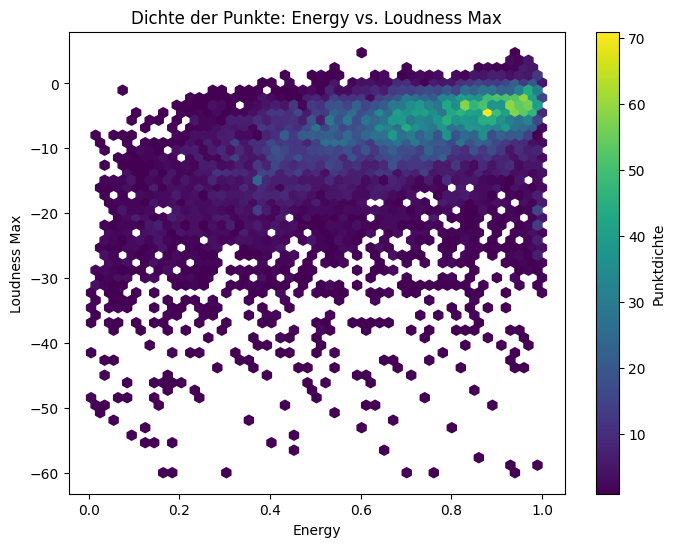

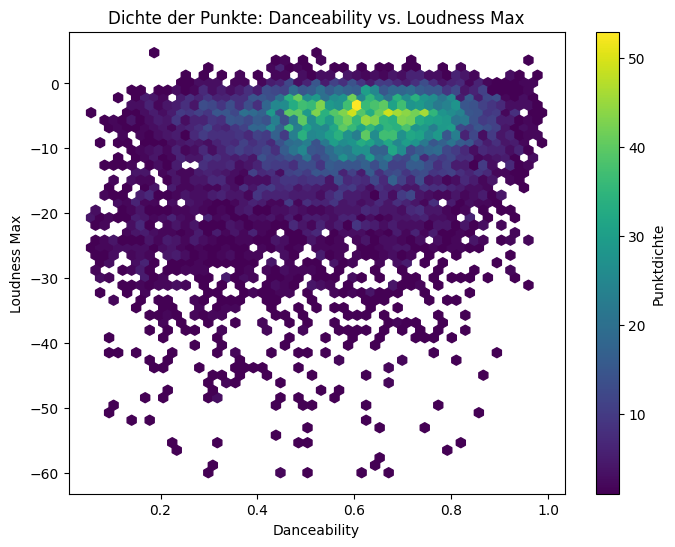

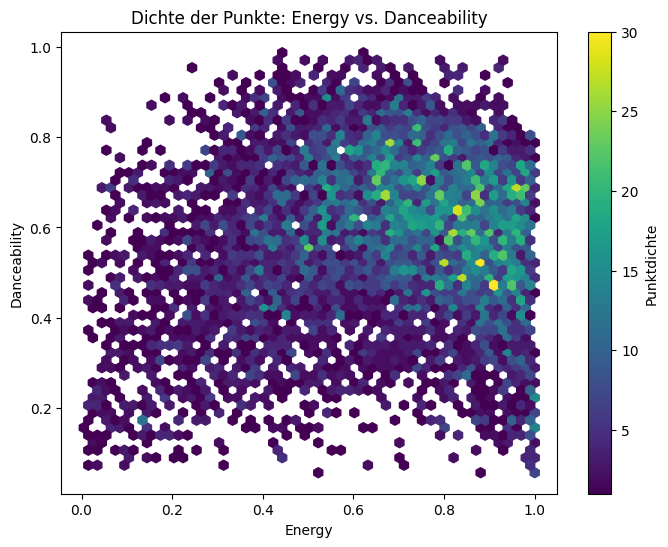

Codeausführung abgeschlossen. Dauer: 3.71 Minuten


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from pyspark.sql.functions import col

# Startzeit messen
start_time = time.time()

# Spark DataFrame vorbereiten
filtered_df = filtered_df.select(
    col("energy").cast("float"),
    col("loudness_max_segment").cast("float"),
    col("danceability").cast("float")
).na.drop()

# Sampling der Daten (10.000 Zeilen für Visualisierung)
sample_size = 10000
sampled_df = filtered_df.sample(fraction=sample_size / filtered_df.count())

# Umwandeln der Stichprobe in Pandas DataFrame
filtered_pd_df = sampled_df.toPandas()

# Visualisierung 1: Hexbin-Dichteplot für Energy vs. Loudness Max
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["energy"], filtered_pd_df["loudness_max_segment"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Energy vs. Loudness Max")
plt.xlabel("Energy")
plt.ylabel("Loudness Max")
plt.show()

# Visualisierung 2: Hexbin-Dichteplot für Danceability vs. Loudness Max
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["danceability"], filtered_pd_df["loudness_max_segment"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Danceability vs. Loudness Max")
plt.xlabel("Danceability")
plt.ylabel("Loudness Max")
plt.show()


#Visualisierung 3: Energy vs. Danceability
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["energy"], filtered_pd_df["danceability"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Energy vs. Danceability")
plt.xlabel("Energy")
plt.ylabel("Danceability")
plt.show()

# Endzeit messen
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Codeausführung abgeschlossen. Dauer: {execution_time_minutes:.2f} Minuten")
   

# !! Dieser Teil muss einmalig ausgeführt werden: Hier wird die CSV Datei so angepasst dass sie korrekt in das Dataframe eingelesen werden kann:

In [11]:
import csv

# Original- und Zielpfade
csv_path = "C:/Users/katri/Documents/hka/adv_data_eng/data/main_dataset.csv"  # Eingabedatei
output_file = "C:/Users/katri/Documents/hka/adv_data_eng/data/main_final_dataset.csv"  # Endgültige Ausgabedatei

# Öffne die Eingabedatei und führe beide Bereinigungen nacheinander durch
with open(csv_path, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8', newline='') as outfile:
    for line in infile:
        # Schritt 1: Entferne `;;;` am Ende der Zeile (falls vorhanden)
        cleaned_line = line.rstrip()  # Entferne Leerzeichen oder Steuerzeichen
        if cleaned_line.endswith(';;;'):
            cleaned_line = cleaned_line[:-3]  # Entferne die letzten drei Zeichen
        
        # Schritt 2: Entferne äußere Anführungszeichen (nur am Anfang und Ende der Zeile)
        if cleaned_line.startswith('"') and cleaned_line.endswith('"'):
            cleaned_line = cleaned_line[1:-1]  # Entferne das erste und letzte Zeichen

        # Schritt 3: Ersetze doppelte Anführungszeichen ("") durch einfache Anführungszeichen (")
        cleaned_line = cleaned_line.replace('""', '"')

        # Schreibe die bereinigte Zeile in die Zieldatei
        outfile.write(cleaned_line + "\n")

print(f"Die Datei wurde komplett verarbeitet und unter {output_file} gespeichert.")


Die Datei wurde komplett verarbeitet und unter C:/Users/katri/Documents/hka/adv_data_eng/data/main_final_dataset.csv gespeichert.


Nach diesen beiden Vorverarbeitungsschritten ist das CSV final fertig um anschließend anhand folgender Bedingunen in das Spark Dataframe eingelesen werden zu können: 
- 1) Nach jedem Komma folgt eine neue Spalte
- 2) Inhalte zwischen Anführungszeichen ("       ") sind eine einzige Spalte